# Model Building

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv('malang_clean.csv')
df.head()

,price,bedroom,hsize,lsize,location_bin
0,320.0,2.0,36.0,72.0,Kedungkandang
1,600.0,3.0,70.0,64.0,other
2,459.0,3.0,65.0,60.0,other
3,227.0,2.0,62.0,43.0,other
4,250.0,2.0,50.0,84.0,other


In [3]:
df.columns

Index(['price', 'bedroom', 'hsize', 'lsize', 'location_bin'], dtype='object')

In [4]:
df.dropna(inplace=True)

In [5]:
df.isnull().sum()

price           0
bedroom         0
hsize           0
lsize           0
location_bin    0
dtype: int64

# Dataset Spliting

In [6]:
X = df.drop(columns='price')
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2082, 4), (521, 4), (2082,), (521,))

# Training Model

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['bedroom', 'hsize', 'lsize']),
    ('categoric', cat_pipe(encoder='onehot'), ['location_bin']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='neg_mean_absolute_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.9s finished


{'algo__colsample_bytree': 0.8284250399306623, 'algo__gamma': 3, 'algo__learning_rate': 0.03253972566577117, 'algo__max_depth': 8, 'algo__n_estimators': 112, 'algo__reg_alpha': 0.002120199469953843, 'algo__reg_lambda': 0.0010489129591818502, 'algo__subsample': 0.6139472074743181}
-183.2196604947091 -331.07273314935685 -297.9457363131561


## Evaluation

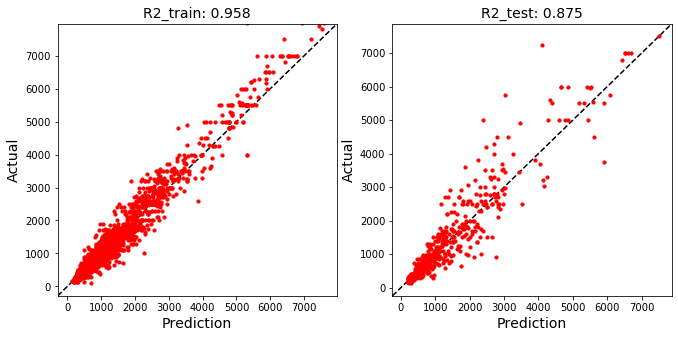

In [9]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

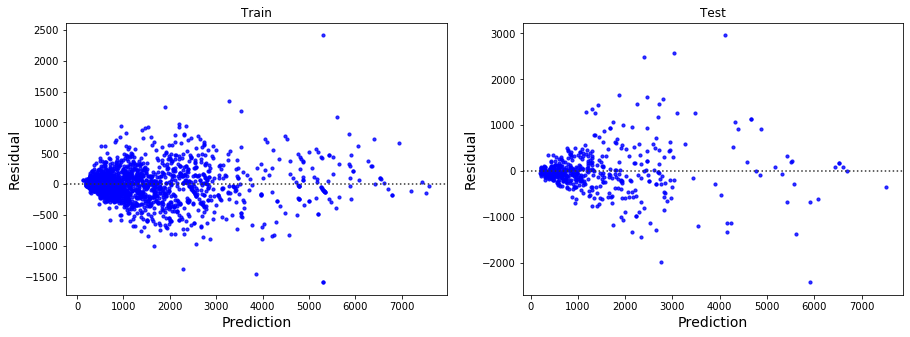

In [10]:
plot_residual(X_train, y_train, X_test, y_test, model)

# Fine Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
params = {
    'algo__max_depth':[4],
    'algo__min_child_weight':[0.3],
    'algo__learning_rate':[0.1, 0.05],
    'algo__gamma':[0.2],
    'algo__colsample_bytree':[1],
    'algo__subsample':[1]
}

In [13]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['bedroom', 'hsize', 'lsize']),
    ('categoric', cat_pipe(encoder='onehot'), ['location_bin']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished


{'algo__colsample_bytree': 1, 'algo__gamma': 0.2, 'algo__learning_rate': 0.05, 'algo__max_depth': 4, 'algo__min_child_weight': 0.3, 'algo__subsample': 1}
-284.05895755456646 -346.1062212212819 -321.5255217844871


## Evaluation

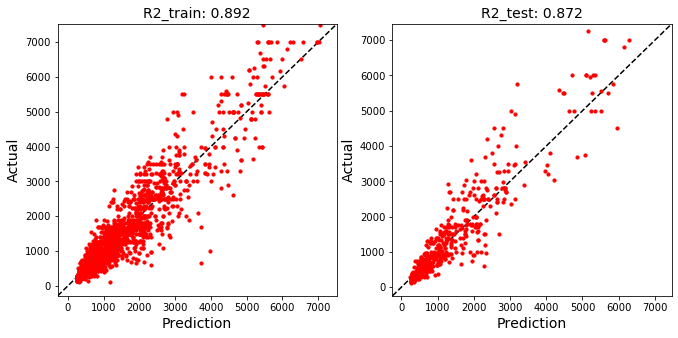

In [14]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

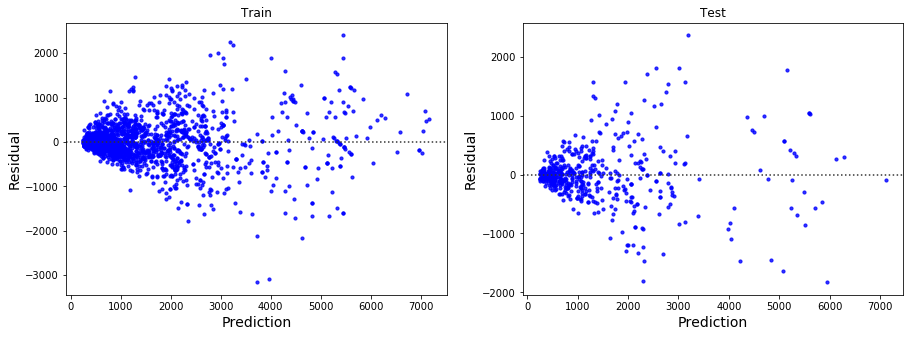

In [15]:
plot_residual(X_train, y_train, X_test, y_test, model)

# Feature Importance

,feature,importance,stdev
2,lsize,532.453783,7.215616
1,hsize,267.248606,5.637484
0,bedroom,19.410780,0.853208
3,location_bin,16.603787,1.101876


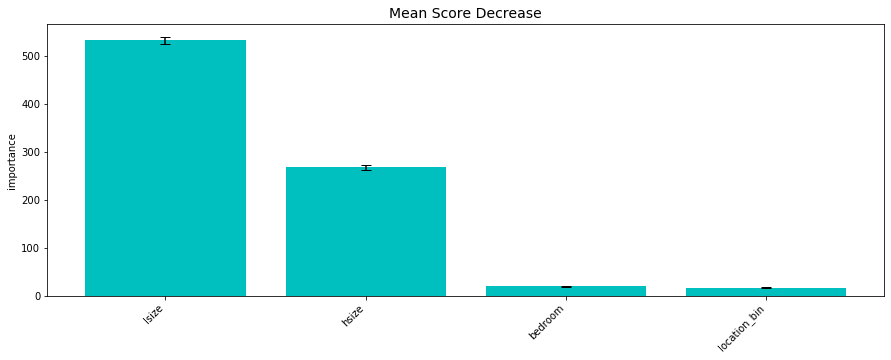

In [16]:
mean_score_decrease(X_train, y_train, model, plot=True)

# Conclusion

- Our model perform overfit in the first training using RandomizedSearchCV with train score 96 % and test score 87.5 %
- After messing with the hyperparameter we can reduce the overfit without reduce the test score so much.
- Then end score is 89% train and 87.2 % test, we reduce 7% overfit only by 0.3 % reduce in test score.
- Residual plot tell us that our model didn't really perform well with price more than 2000, we need more data and features so the models can predict more accurately.
- For xgboost lsize and hsize are important to predict price of a house.

# Save Model

In [17]:
save_model(model.best_estimator_, "xgboost.pkl")

Model is pickled as model/xgboost.pkl
